# Understand Scientific Workloads in Sage
This Python notebook parses tegrastats to understand the performance of a workload.

In [14]:
%pip install scipy==1.13
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

from scipy.integrate import simps


Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: distro-info 1.1build1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.43ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [15]:
def parse_power(value: str) -> float:
    if value.endswith("mW"):
        return float(value[:-2]) / 1000  # Convert mW to W
    elif value.endswith("W"):
        return float(value[:-1])  # Already in W
    else:
        raise ValueError(f"Unknown power unit in value: {value}")

def parse_tegrastats(filepath: Path):
    # Parse the tegrastats file
    # Example: 03-26-2025 13:33:37 RAM 996/6854MB (lfb 641x4MB) SWAP 0/3427MB (cached 0MB) CPU [90%@1419,25%@1416,7%@1421,0%@1419,0%@1420,0%@1421] EMC_FREQ 0%@1600 GR3D_FREQ 0%@[114] VIC_FREQ 601 APE 150 AUX@40.5C CPU@41C thermal@40.35C AO@40.5C GPU@40C PMIC@50C VDD_IN 2939mW/2939mW VDD_CPU_GPU_CV 489mW/489mW VDD_SOC 774mW/774mW
    with open(filepath, 'r') as f:
        lines = f.readlines()
    data = []
    for line in lines:
        parts = line.strip().split()
        timestamp = f"{parts[0]} {parts[1]}"
        ram_usage = parts[3].split('/')[0]
        cpu_usage = parts[11].strip('[]')
        total_power = parse_power(parts[-5].split('/')[0])
        cpugpu_power = parse_power(parts[-3].split('/')[0])
        data.append(
            {
                'timestamp': timestamp,
                'ram_usage': ram_usage,
                'cpu_usage': cpu_usage,
                'total_power': total_power,
                'cpugpu_power': cpugpu_power})
    data = pd.DataFrame(data)
    return data

In [16]:
df = parse_tegrastats(Path("data/nx_smoke_tegrastats.txt"))
df["total_power_app"] = df["total_power"] - df["total_power"].min()

<Axes: xlabel='timestamp'>

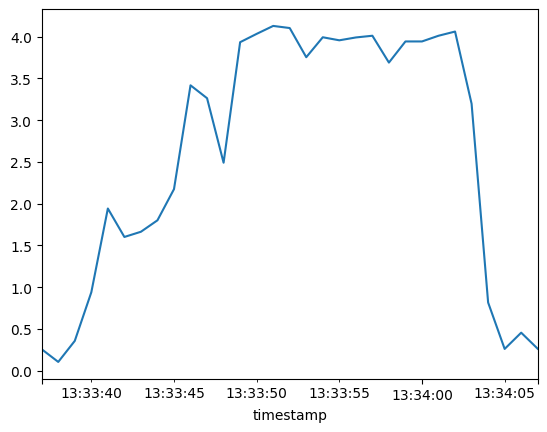

In [17]:
grouped["total_power_app"].plot()

In [18]:
time_deltas

Index([ 0.0,  1.0,  2.0,  3.0,  4.0,  5.0,  6.0,  7.0,  8.0,  9.0, 10.0, 11.0,
       12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0,
       24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0],
      dtype='float64', name='timestamp')

In [19]:

df["timestamp"] = pd.to_datetime(df["timestamp"])  # Convert timestamp to datetime
grouped = df.groupby("timestamp")[["total_power_app"]].mean()  # Exclude timestamp from aggregation
# Calculate the integral of total_power_app over time
timestamps = pd.to_datetime(grouped.index)
time_deltas = (timestamps - timestamps.min()).total_seconds()
integral = simps(grouped["total_power_app"], time_deltas)
print(f"Total energy consumption: {integral} J ({integral / 3600} Wh) over {time_deltas[-1]} seconds")

Total energy consumption: 79.84277804232804 J (0.02217854945620223 Wh) over 30.0 seconds


/tmp/ipykernel_5879/1954794245.py:6: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  integral = simps(grouped["total_power_app"], time_deltas)


In [20]:
import numpy as np
from scipy.integrate import simps

# Define the function and the interval
x = np.linspace(0, 10, 100)  # 100 points between 0 and 10
y = 2 * x  # f(x) = 2x

# Calculate the integral using simps
calculated_integral = simps(y, x)

# Print the result
print(f"x: {x}")
print(f"y: {y}")
print(f"Calculated integral: {calculated_integral}")
print("Expected integral: 100")

x: [ 0.          0.1010101   0.2020202   0.3030303   0.4040404   0.50505051
  0.60606061  0.70707071  0.80808081  0.90909091  1.01010101  1.11111111
  1.21212121  1.31313131  1.41414141  1.51515152  1.61616162  1.71717172
  1.81818182  1.91919192  2.02020202  2.12121212  2.22222222  2.32323232
  2.42424242  2.52525253  2.62626263  2.72727273  2.82828283  2.92929293
  3.03030303  3.13131313  3.23232323  3.33333333  3.43434343  3.53535354
  3.63636364  3.73737374  3.83838384  3.93939394  4.04040404  4.14141414
  4.24242424  4.34343434  4.44444444  4.54545455  4.64646465  4.74747475
  4.84848485  4.94949495  5.05050505  5.15151515  5.25252525  5.35353535
  5.45454545  5.55555556  5.65656566  5.75757576  5.85858586  5.95959596
  6.06060606  6.16161616  6.26262626  6.36363636  6.46464646  6.56565657
  6.66666667  6.76767677  6.86868687  6.96969697  7.07070707  7.17171717
  7.27272727  7.37373737  7.47474747  7.57575758  7.67676768  7.77777778
  7.87878788  7.97979798  8.08080808  8.18181818

/tmp/ipykernel_5879/4182060634.py:9: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  calculated_integral = simps(y, x)
